In [1]:

import numpy as np
import os
import cv2
import glob
import cPickle as pickle
import matplotlib.pyplot as plt
import os
import joblib
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from skimage.feature import hog


import matplotlib.image as mpimg

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import LinearSVC

# Import everything needed to edit/save/watch video clips
from moviepy import editor # import VideoFileClip
from IPython import display # import HTML

#%matplotlib qt
%matplotlib inline

# Utility functions

In [3]:


def collect_images(path):
    images = []
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            if name.startswith('.'):
                continue
            images.append(os.path.join(root, name))
    return images

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist


# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors





# Read vehicle and non-vehicle images

In [4]:
cars = []
notcars = []

cars = collect_images('data/vehicles/vehicles')
notcars = collect_images('data/non-vehicles/non-vehicles')

        
print('cars',len(cars))
print('notcars', len(notcars))

('cars', 8792)
('notcars', 8968)


# Define parameters for feature extraction

In [5]:

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print 'Car samples: ', len(car_features)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print 'Notcar samples: ', len(notcar_features)

### save extracted features for easy reload

In [90]:
joblib.dump([car_features, notcar_features], 'features1.pkl')

['features1.pkl']

In [723]:
# load features

#car_features, notcar_features = joblib.load( 'features1.pkl')

# Train a linear SVC 

In [17]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC



('Using:', 8, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 2432)
(7.3, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9866)


# print sample images and feature histogram

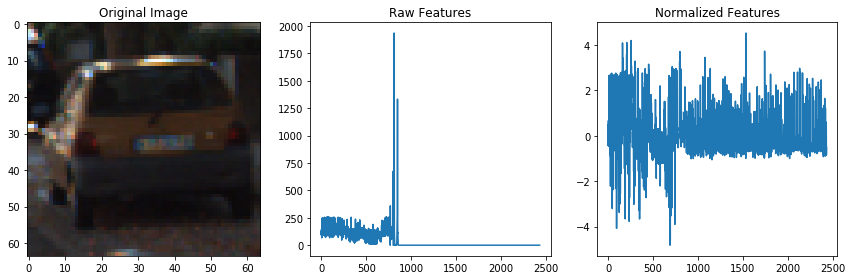

In [25]:

car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

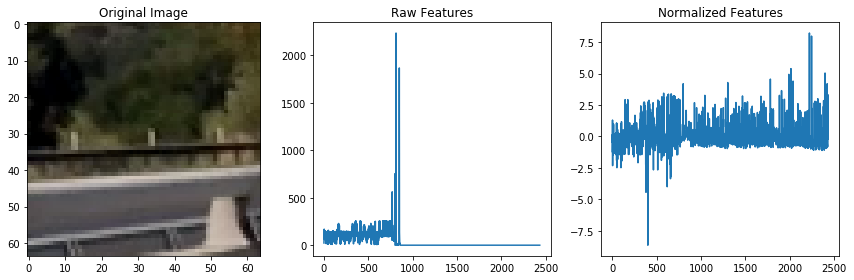

In [21]:
car_ind = np.random.randint(0, len(notcars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(notcars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((28416, 2432), (7104, 2432), (28416,), (7104,))


In [27]:
joblib.dump([X, y], 'Xy.pkl')
joblib.dump(svc, 'svc.pkl')
joblib.dump(X_scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
X, y = joblib.load( 'Xy.pkl')
svc = joblib.load('svc.pkl')
X_scaler = joblib.load('scaler.pkl')

# Define functions for car detection using sliding windows

In [8]:


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

# Test  sample detections:

(0.85, 'Seconds to process test images')


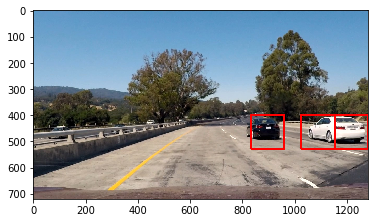

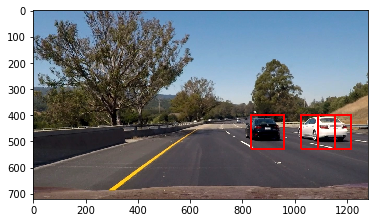

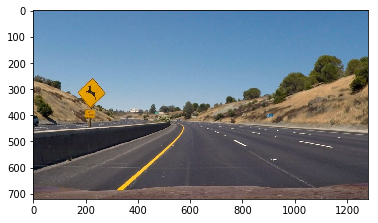

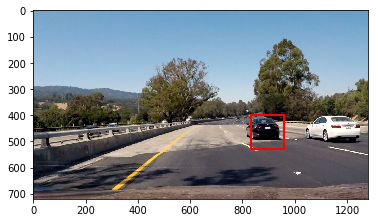

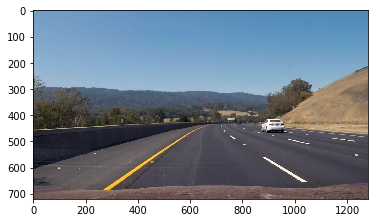

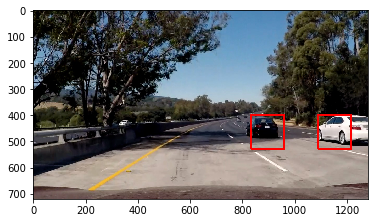

In [9]:


t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')



# Advandced window search

As can be seen in above images, some cars go undetected. One way of dealing with this is by using multiple window sizes. Also, We need not search for same size car all over the image. We need to search bottom half of image and gradually increase the window size as we go from top to bottom to reflect the fact that cars at a distance will be near of image (height).

In addition, here's a tuned area for new car detection:

    1) on the sides of car
    2) on the road horizon

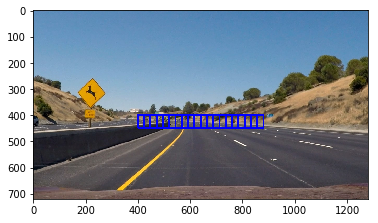

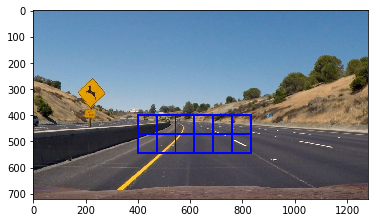

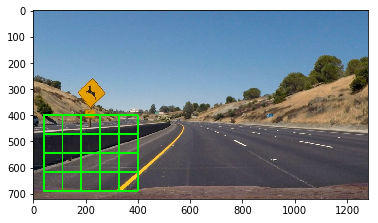

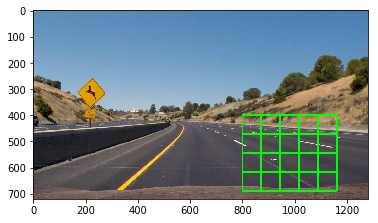

In [682]:
image = cv2.imread('test_images/test2.jpg')

windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 570], 
                    xy_window=(72, 72), xy_overlap=(0., 0.))
window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

windows = slide_window(image, x_start_stop=[40, 400], y_start_stop=[400, 700], 
                    xy_window=(72, 72), xy_overlap=(0., 0.))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)                    
show_img(window_img)

windows = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[400, 700], 
                    xy_window=(72, 72), xy_overlap=(0., 0.))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)                    
show_img(window_img)

In [11]:

def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[int(ystart):int(ystop),int(xstart):int(xstop),:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

# Lane lines, vehicle detection and tracking

The lanelines repository (from project 4) is cloned within project directory, and can be imported as:


In [724]:
from lanelines import lanelines

In [671]:


from scipy.ndimage import measurements

def global_init():
    global THRES
    global ALPHA
    global track_list
    global TRACK_FRAMES
    global Y_MIN
    global heat_p
    global heat_p
    global boxes_p
    global n_count
    global PLOT
    global last_rad
    global last_l_poly
    global last_r_poly
    global tracker
    global min_box_overlap
    
    TRACK_FRAMES = 5
    n_count = 0 # Frame counter

    PLOT = False
    last_rad = None
    last_l_poly = None
    last_r_poly = None
    
    tracker = Tracker(TRACK_FRAMES)
    min_box_overlap = 3
    
    
global_init()

In [726]:
from collections import deque
import numpy as np



def bounding_boxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
        #bbox_dict
    # Return the image
    return bboxes


class BBox(object):
    def __init__(self, bbox):
        self.bbox = bbox
        self.x, self.y = self._center(bbox)
        self.h, self.w = self._dim(bbox)
    
    def _center(self, bbox):
        (x1, y1), (x2, y2) = bbox
        x = (x1 + x2)/2.
        y = (y1 + y2)/2.
        return x, y
    
    def _dim(self, bbox):
        (x1, y1), (x2, y2) = bbox
        h = abs(y1 - y2)
        w = abs(x1 - x2)
        return h, w
        

class Tracker(object):
    def __init__(self, track_len):
        self.labeled_boxes = []
        self.track_list = deque(maxlen=track_len)
        self.heatmap = None
        self._heatmap = None
        self.labels = None
        self.tracked_boxes = []
        
        
    def fuse_heatmap(self, new_heatmap):
        self.track_list.append(new_heatmap)
        self._heatmap = np.zeros_like(new_heatmap)
        # insert new heap map to deque
        
        sum_wt = 0
        for e,array in enumerate(self.track_list):
            self._heatmap +=  array
            #sum_wt += (e +1)
        self._heatmap = self._heatmap / float(len(self.track_list))
        #self._heatmap = self._heatmap / float(sum_wt)
        
        heat = HeatMap(self._heatmap)
        self.heatmap = heat.clip().heatmap
        self.labels = heat.get_labels()
        return self
        
    def labels_to_bboxes(self, labels):
        bboxes = []
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            bboxes.append(bbox)
            
        # Return the image
        return bboxes
    
    
    def bbox_dim(self, bbox):
        """Top left corner, height, width."""
        x = min(x1,x2)
        y = min(y1, y2)
        h = abs(y1 - y2)
        w = abs(x1 - x2)
        return x, y, h, w
                 

    
class HeatMap(object):
    def __init__(self, heatmap, threshold=0):
        self.heatmap = heatmap
        self.threshold = threshold
    
    def add_heat(self, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return self

    def apply_threshold(self, threshold=None): 
        """Zero out pixels below the threshold in the heatmap"""
        if threshold is None:
            threhsold = self.threshold
        self.heatmap[self.heatmap < threshold] = 0.
        return self
    
    def clip(self, cmin=0, cmax=255):
        self.heatmap = np.clip(self.heatmap, cmin, cmax)
        return self
    
    def get_labels(self):
        return measurements.label(self.heatmap)
    
    def fuse(self, bbox_list, threshold=None, cmin=0, cmax=255):
        self.add_heat(bbox_list)
        self.apply_threshold(threshold=threshold)
        self.clip(cmin=cmin, cmax=cmax)
        return self
    



def frame_proc(img, lane = False, video = False, vis = False):
    global tracker
    global min_box_overlap
    global n_count
    global boxes
    
    if (video and n_count%2==0) or not video: # Skip every second video frame
        boxes = []

        if n_count == 0:
           boxes += find_cars(img, 400, 460, 400, 800, .75, 1)
           boxes += find_cars(img, 400, 600, 400, 800, 2, 1)
           boxes += find_cars(img, 400, 700, 400, 800, 3, 1)
        
        boxes += find_cars(img, 400, 500, 300, 1000, 1, 1)

        boxes += find_cars(img, 400, 600, 800, 1280, 1.8, 1)

        boxes += find_cars(img, 400, 600, 0, 400, 1.8, 1)
        
        heat_init = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = HeatMap(heat_init, threshold=min_box_overlap)
        new_heatmap = heat.fuse(boxes,threshold=min_box_overlap).heatmap
        #plt.imshow(new_heatmap)
        #plt.show()
        
        tracker.fuse_heatmap(new_heatmap)
        heatmap = tracker.heatmap
        plt.imshow(heatmap)
        plt.show()
        labels = tracker.labels
        
        cars_boxes = bounding_boxes(labels)
        
        tracker.labeled_boxes = cars_boxes
        
    else:
        cars_boxes = tracker.labeled_boxes
    if lane: #If we was asked to draw the lane line, do it
        img = lanelines.draw_lanes(img, last_rad, last_l_poly, last_r_poly, PLOT)
    img = draw_boxes(np.copy(img), cars_boxes, color=(0, 0, 255), thick=6)
    if vis:
        img = draw_boxes(img, boxes, color=(0, 255, 255), thick=2)
    n_count += 1
    return img


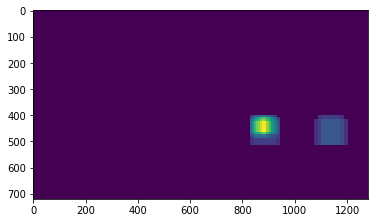

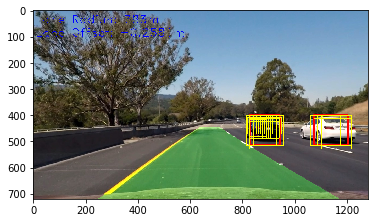

In [731]:
_img = 'test_images/test6.jpg'
image = mpimg.imread(_img)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
global_init()
# PLOT = True
show_img(frame_proc(image, lane=True, vis=True))

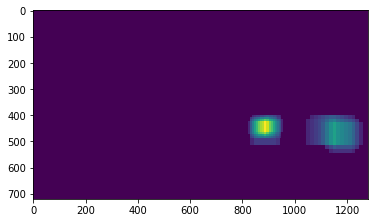

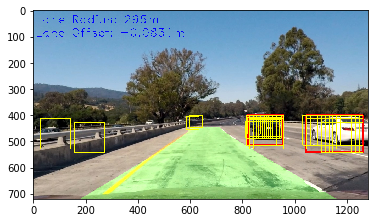

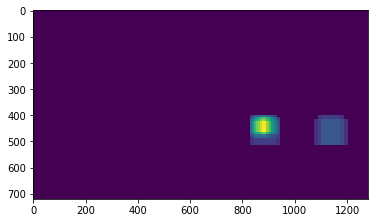

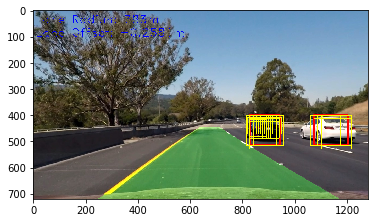

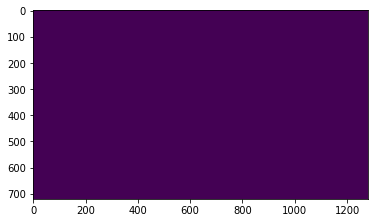

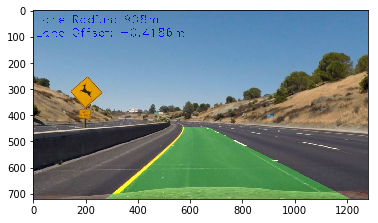

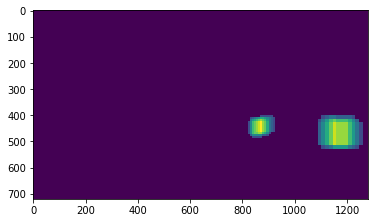

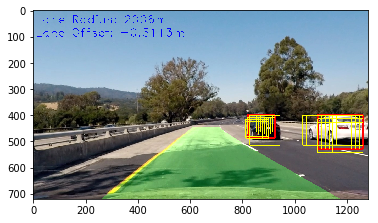

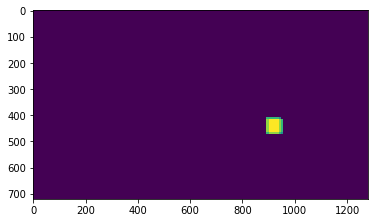

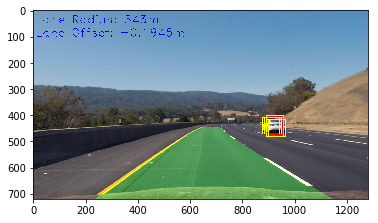

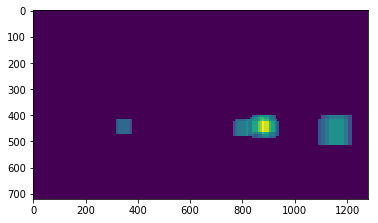

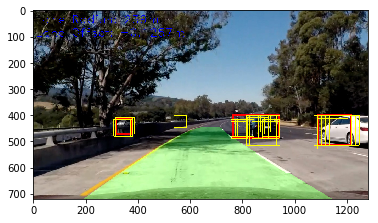

In [717]:
import ntpath

images = glob.glob('test_images/*.jpg')
# image = mpimg.imread('test_images/test5.jpg')
for i,_img in enumerate(images):
    image = mpimg.imread(_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.figure(i+1)
    global_init()
    # PLOT=True
    img = frame_proc(image, lane=True, vis=True)
    show_img(img)
    
    
    image_name = ntpath.basename(_img)
    cv2.imwrite( os.path.join('output', image_name),img)


plt.show()

In [668]:
# process video
from moviepy.editor import VideoFileClip

In [718]:
# a short clip from project video for running tests 
# taken at 43 seconds with lenth 3 sec
clip_name = "4303"


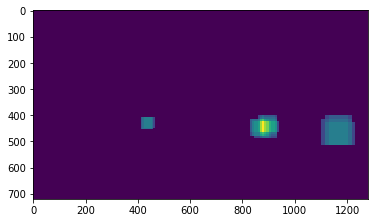

[MoviePy] >>>> Building video output/project_video_4303.mp4
[MoviePy] Writing video output/project_video_4303.mp4


  1%|          | 1/101 [00:01<02:14,  1.35s/it]

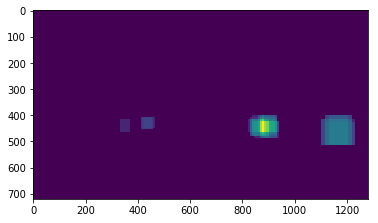

  3%|▎         | 3/101 [00:03<02:08,  1.31s/it]

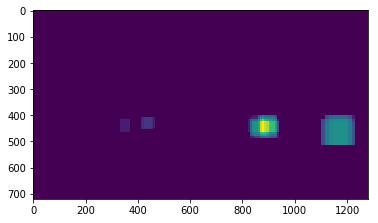

  5%|▍         | 5/101 [00:06<01:55,  1.20s/it]

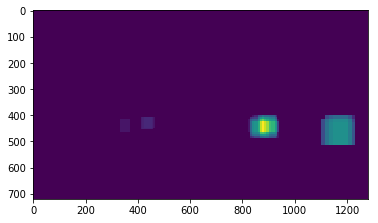

  7%|▋         | 7/101 [00:08<01:50,  1.18s/it]

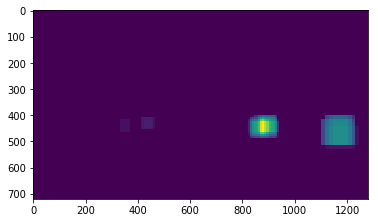

  9%|▉         | 9/101 [00:11<01:53,  1.24s/it]

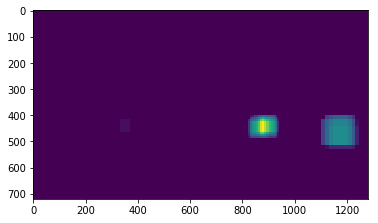

 11%|█         | 11/101 [00:15<02:21,  1.58s/it]

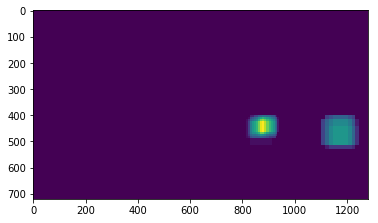

 13%|█▎        | 13/101 [00:18<02:06,  1.43s/it]

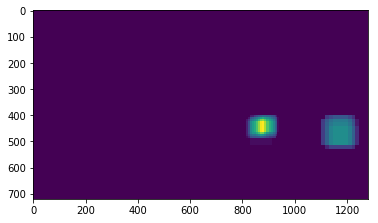

 15%|█▍        | 15/101 [00:21<02:22,  1.65s/it]

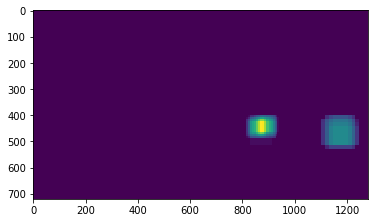

 17%|█▋        | 17/101 [00:26<02:47,  1.99s/it]

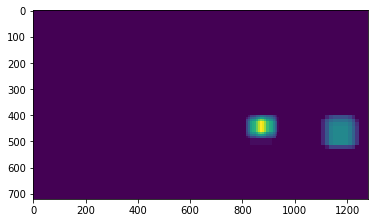

 19%|█▉        | 19/101 [00:35<04:33,  3.33s/it]

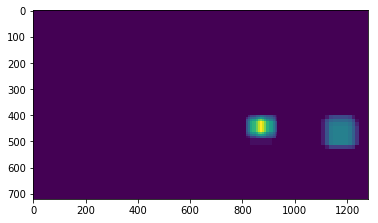

 21%|██        | 21/101 [00:49<06:47,  5.10s/it]

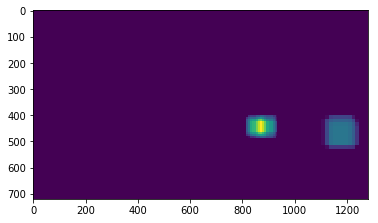

 23%|██▎       | 23/101 [01:04<07:49,  6.02s/it]

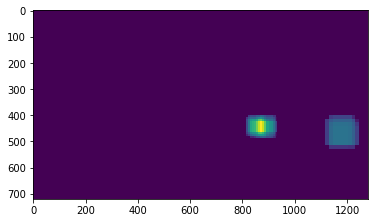

 25%|██▍       | 25/101 [01:16<07:30,  5.93s/it]

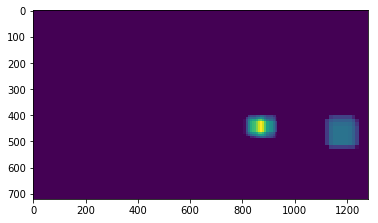

 27%|██▋       | 27/101 [01:21<05:14,  4.24s/it]

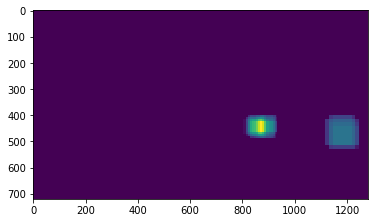

 29%|██▊       | 29/101 [01:27<04:07,  3.44s/it]

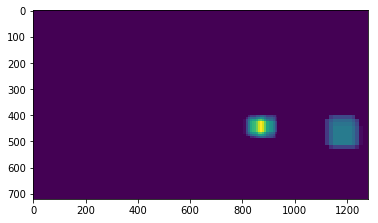

 31%|███       | 31/101 [01:32<03:23,  2.90s/it]

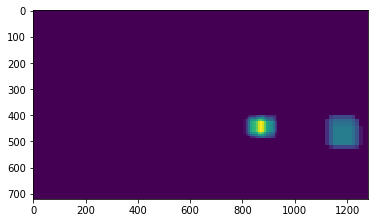

 33%|███▎      | 33/101 [01:35<02:34,  2.28s/it]

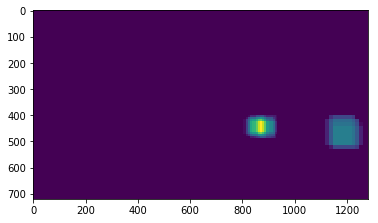

 35%|███▍      | 35/101 [01:39<02:09,  1.97s/it]

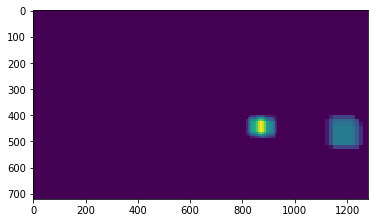

 37%|███▋      | 37/101 [01:42<01:56,  1.82s/it]

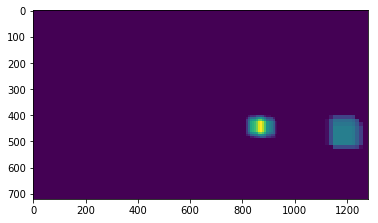

 39%|███▊      | 39/101 [01:47<02:10,  2.10s/it]

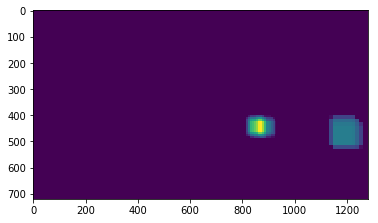

 41%|████      | 41/101 [01:52<02:20,  2.35s/it]

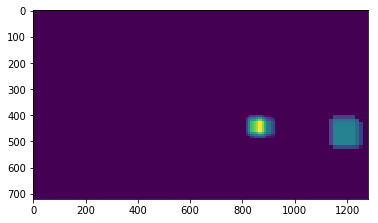

 43%|████▎     | 43/101 [01:58<02:30,  2.60s/it]

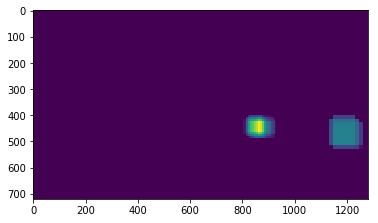

 45%|████▍     | 45/101 [02:03<02:24,  2.58s/it]

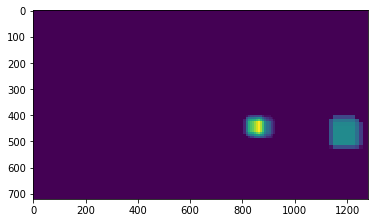

 47%|████▋     | 47/101 [02:09<02:18,  2.56s/it]

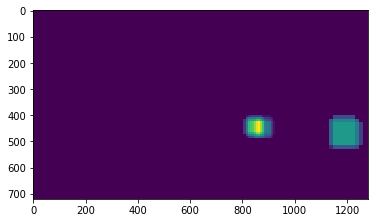

 49%|████▊     | 49/101 [02:14<02:12,  2.55s/it]

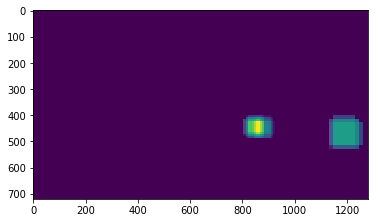

 50%|█████     | 51/101 [02:19<02:09,  2.58s/it]

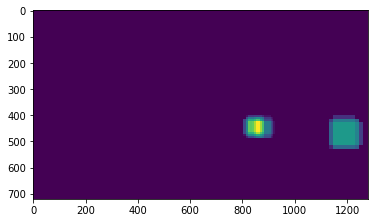

 52%|█████▏    | 53/101 [02:25<02:04,  2.60s/it]

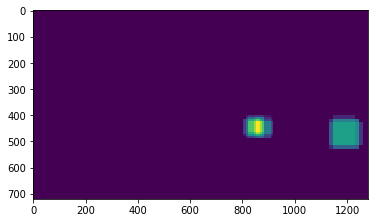

 54%|█████▍    | 55/101 [02:30<02:00,  2.61s/it]

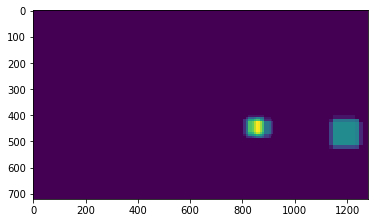

 56%|█████▋    | 57/101 [02:36<01:54,  2.60s/it]

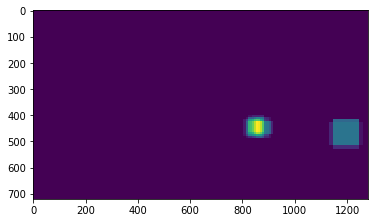

 58%|█████▊    | 59/101 [02:41<01:49,  2.61s/it]

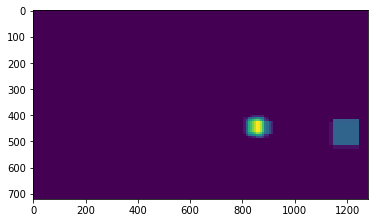

 60%|██████    | 61/101 [02:47<01:44,  2.61s/it]

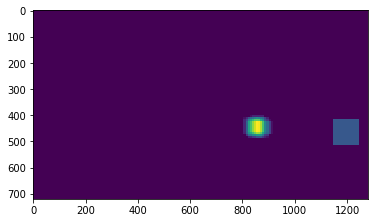

 62%|██████▏   | 63/101 [02:52<01:39,  2.61s/it]

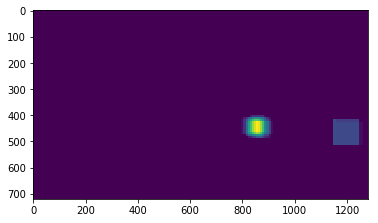

 64%|██████▍   | 65/101 [02:56<01:21,  2.25s/it]

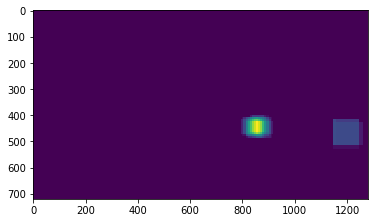

 66%|██████▋   | 67/101 [03:00<01:06,  1.97s/it]

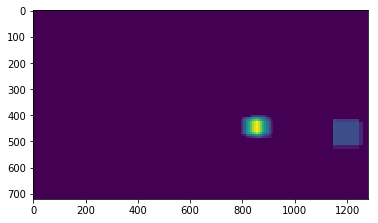

 68%|██████▊   | 69/101 [03:03<00:57,  1.81s/it]

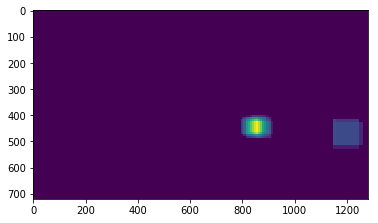

 70%|███████   | 71/101 [03:07<00:52,  1.75s/it]

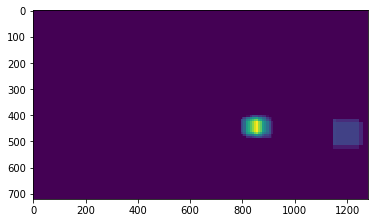

 72%|███████▏  | 73/101 [03:11<00:56,  2.02s/it]

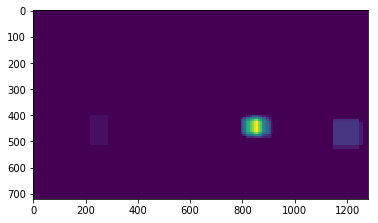

 74%|███████▍  | 75/101 [03:16<00:59,  2.30s/it]

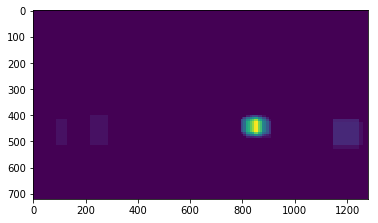

 76%|███████▌  | 77/101 [03:26<01:25,  3.57s/it]

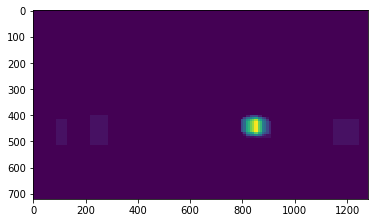

 78%|███████▊  | 79/101 [03:37<01:40,  4.55s/it]

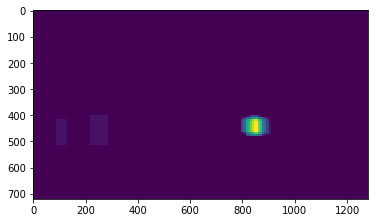

 80%|████████  | 81/101 [03:43<01:10,  3.54s/it]

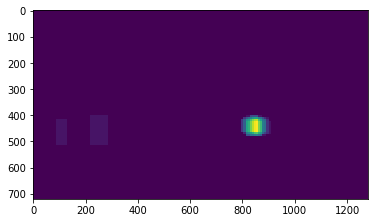

 82%|████████▏ | 83/101 [03:48<00:55,  3.06s/it]

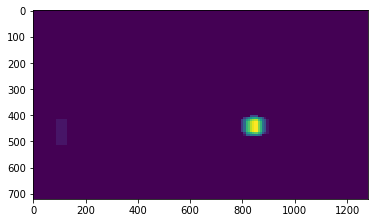

 84%|████████▍ | 85/101 [03:53<00:41,  2.59s/it]

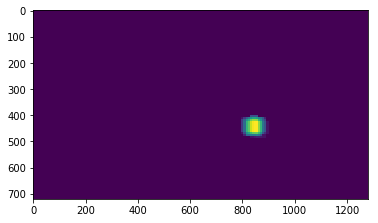

 86%|████████▌ | 87/101 [03:56<00:29,  2.10s/it]

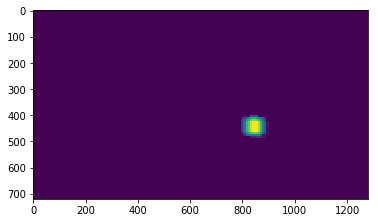

 88%|████████▊ | 89/101 [04:00<00:22,  1.86s/it]

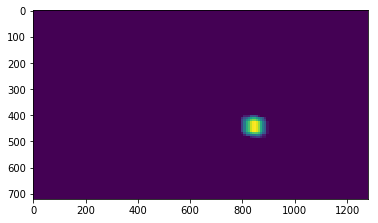

 90%|█████████ | 91/101 [04:03<00:17,  1.74s/it]

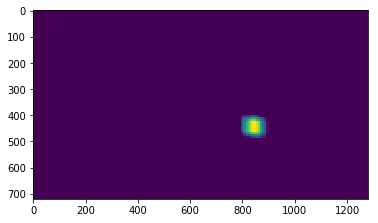

 92%|█████████▏| 93/101 [04:07<00:15,  1.94s/it]

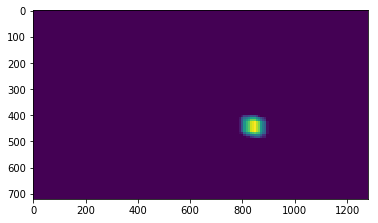

 94%|█████████▍| 95/101 [04:12<00:13,  2.26s/it]

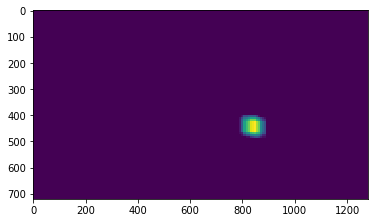

 96%|█████████▌| 97/101 [04:17<00:09,  2.28s/it]

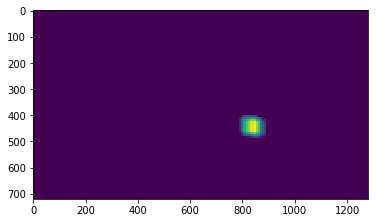

 98%|█████████▊| 99/101 [04:21<00:03,  1.96s/it]

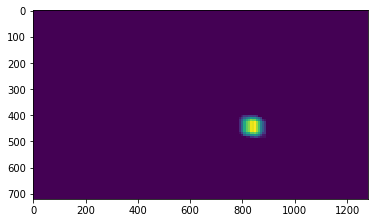

100%|██████████| 101/101 [04:24<00:00,  1.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_4303.mp4 

CPU times: user 4min 38s, sys: 19.9 s, total: 4min 58s
Wall time: 4min 25s


In [719]:
global_init()
n_count = 0
# laneline.init_params(0.0)
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=True, video=True, vis=True), cv2.COLOR_BGR2RGB)

output_v = 'output/project_video_{}.mp4'.format(clip_name)
clip1 = VideoFileClip("project_video_{}.mp4".format(clip_name))
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)


In [721]:
global_init()
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=True, video=True, vis=False), cv2.COLOR_BGR2RGB)

output_v = 'output/project_video_out3.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video output/project_video_out3.mp4
[MoviePy] Writing video output/project_video_out3.mp4


100%|█████████▉| 1260/1261 [51:51<00:02,  2.08s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_out3.mp4 

CPU times: user 54min 38s, sys: 11.2 s, total: 54min 49s
Wall time: 51min 51s


In [722]:
global_init()
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(frame_proc(image, lane=True, video=True, vis=False), cv2.COLOR_BGR2RGB)

output_v = 'output/test_video_out3.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video output/test_video_out3.mp4
[MoviePy] Writing video output/test_video_out3.mp4


 97%|█████████▋| 38/39 [01:15<00:01,  1.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/test_video_out3.mp4 

CPU times: user 1min 19s, sys: 688 ms, total: 1min 20s
Wall time: 1min 15s
